<a href="https://colab.research.google.com/github/joaosMart/fish-species-class-siglip/blob/main/Code/multi-fish-detection/Video_Level_MultiFish_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fish Video Segment Selection for Species Classification

This notebook implements the video-level multiple fish detection and first valid segment selection methodology described in "Temporal Aggregation of Vision-Language Features for High-Accuracy
Fish Classification in Automated Monitoring".


## Overview
The pipeline filters videos containing multiple fish and selects the first valid fish segment for species classification, ensuring each video corresponds to a single fish individual as required by the temporal aggregation approach.


## Key Components:
1. **Video-level Multiple Fish Detection**: Identifies videos with fish in separate sequences.

2. **First Valid Segment Selection**: Extracts the first temporally continuous fish appearance.

3. **Segment Quality Filtering**: Ensures segments meet minimum length requirements for temporal analysis


## Requirements
- Frame-level fish detection results (JSON format)
- Multi-fish classification predictions (pickle format). This comes from the ```Detecting Multiple Fishes by Scores.ipynb``` notebook.
- Species classification labels (CSV). For this we used a .csv file that had the path to the videos saved and the labels for that species. A similar file with paths and labels on separated columns should work.

In [1]:
import json
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
from tqdm import tqdm

## Data Loading and Preparation

In [11]:



def load_detection_results(json_path: str, pickle_path: str) -> Dict:
    """
    Load and combine frame-level fish detection with multi-fish predictions.

    Args:
        json_path: Path to fish detection results JSON
        pickle_path: Path to multi-fish classification predictions pickle

    Returns:
        Dictionary mapping video paths to frame predictions with multi-fish probabilities
    """
    print("Loading detection results...")

    # Load original JSON with frame numbers
    with open(json_path, 'r') as f:
        original_data = json.load(f)

    # Load multi-fish predictions
    with open(pickle_path, 'rb') as f:
        multi_fish_data = pickle.load(f)

    print("Creating frame-level mapping...")
    frame_mapping = {}

    for video_path, video_data in tqdm(original_data.items()):
        if len(video_data['fish_frames']) == 0:
            continue

        if video_path not in multi_fish_data['results']:
            #print(f"Warning: Video {video_path} not found in multi-fish predictions")
            continue

        frame_predictions = multi_fish_data['results'][video_path]
        frame_numbers = [frame['frame'] for frame in video_data['fish_frames']]


        # Create structured frame predictions
        video_frame_data = []
        for frame_num, prediction in zip(frame_numbers, frame_predictions):
            original_prob = next(
                frame['probability'] for frame in video_data['fish_frames']
                if frame['frame'] == frame_num
            )

            video_frame_data.append({
                'frame_number': frame_num,
                'original_probability': original_prob,
                'single_fish_probability': float(prediction[0]),
                'multiple_fish_probability': float(prediction[1])
            })

        frame_mapping[video_path] = {
            'total_frames': video_data['total_frames'],
            'frame_predictions': video_frame_data
        }

    print(f"Successfully mapped {len(frame_mapping)} videos")
    return frame_mapping




## Video-Level Multiple Fish Detection


In [3]:

def filter_multi_fish_videos(video_predictions: Dict, threshold: float = 0.962,
                            consecutive_frames: int = 2) -> Dict:
    """
    Filter out videos with multiple fish based on consecutive frame analysis.

    This implements the video-level multiple fish detection described in Section 2.6.2
    of the paper, identifying videos where fish appear in separate sequences.

    Args:
        video_predictions: Dictionary of video frame predictions
        threshold: Probability threshold for multiple fish detection (default: 0.962)
        consecutive_frames: Minimum consecutive frames above threshold

    Returns:
        Dictionary with filtering results for each video
    """
    print(f"Filtering videos with threshold {threshold} and {consecutive_frames} consecutive frames...")

    filtered_results = {}

    for video_path, data in video_predictions.items():
        frame_predictions = data['frame_predictions']

        # Check for consecutive frames above threshold
        consecutive_count = 0
        max_consecutive = 0
        frames_above_threshold = 0

        for frame in frame_predictions:
            if frame['multiple_fish_probability'] > threshold:
                consecutive_count += 1
                frames_above_threshold += 1
                max_consecutive = max(max_consecutive, consecutive_count)
            else:
                consecutive_count = 0

        # Video meets multiple fish criteria if it has enough consecutive frames
        meets_criteria = frames_above_threshold > consecutive_frames

        filtered_results[video_path] = {
            'has_multiple_fish': meets_criteria,
            'max_consecutive_frames': max_consecutive,
            'total_frames_above_threshold': frames_above_threshold
        }

    # Print summary statistics
    total_videos = len(filtered_results)
    multi_fish_videos = sum(1 for result in filtered_results.values() if result['has_multiple_fish'])

    print(f"Video filtering summary:")
    print(f"  Total videos analyzed: {total_videos}")
    print(f"  Videos with multiple fish: {multi_fish_videos} ({multi_fish_videos/total_videos*100:.1f}%)")
    print(f"  Single fish videos retained: {total_videos - multi_fish_videos}")

    return filtered_results

def remove_multi_fish_videos(video_data: Dict, filter_results: Dict) -> Dict:
    """Remove videos identified as containing multiple fish."""
    single_fish_data = {}

    for video_path, data in video_data.items():
        if video_path in filter_results and not filter_results[video_path]['has_multiple_fish']:
            single_fish_data[video_path] = data

    print(f"Retained {len(single_fish_data)} single-fish videos for segment selection")
    return single_fish_data

## First Valid Segment Detection

In [4]:
def find_first_valid_segment(frame_predictions: List[Dict], min_skip: int = 3,
                           min_segment_length: int = 11, gap_threshold: int = 11) -> Tuple[List[Dict], str, int]:
    """
    Find the first valid fish segment based on the deterministic algorithm described in Section 2.6.2.

    The algorithm implements the following logic:
    - Skip segments < min_skip frames and look for next segment
    - Drop videos with first segment between min_skip and min_segment_length frames
    - Accept segments >= min_segment_length frames

    Args:
        frame_predictions: List of frame predictions for a video
        min_skip: Minimum size below which to skip to next segment (default: 3)
        min_segment_length: Minimum segment length to accept (default: 11)
        gap_threshold: Frame gap size to define segment boundaries (default: 11)

    Returns:
        Tuple of (segment_predictions, status, segment_number)
    """
    if not frame_predictions:
        return [], 'dropped', 0

    # Sort by frame number
    frame_predictions.sort(key=lambda x: x['frame_number'])
    frame_numbers = [pred['frame_number'] for pred in frame_predictions]

    # Find segment boundaries based on gaps > gap_threshold
    gaps = np.diff(frame_numbers)
    gap_indices = np.where(gaps > gap_threshold)[0]

    # If no gaps, treat all frames as one segment
    if len(gap_indices) == 0:
        segment_size = len(frame_numbers)
        if segment_size < min_skip:
            return [], 'dropped', 0
        elif segment_size < min_segment_length:
            return [], 'dropped', 1
        else:
            return frame_predictions, 'accepted', 1

    # Process segments sequentially
    start_idx = 0
    segment_number = 1

    for gap_idx in gap_indices:
        segment_size = gap_idx - start_idx + 1

        if segment_number == 1:  # First segment
            if segment_size < min_skip:
                # Skip to next segment
                start_idx = gap_idx + 1
                segment_number += 1
                continue
            elif segment_size < min_segment_length:
                # Drop video - first segment too short
                return [], 'dropped', 1
            else:
                # Accept first segment
                return frame_predictions[start_idx:gap_idx + 1], 'accepted', 1
        else:  # Later segments
            if segment_size >= min_segment_length:
                return frame_predictions[start_idx:gap_idx + 1], 'used_later_segment', segment_number

        start_idx = gap_idx + 1
        segment_number += 1

    # Check final segment
    final_segment_size = len(frame_numbers) - start_idx
    if segment_number == 1:  # Still first segment
        if final_segment_size < min_skip:
            return [], 'dropped', 1
        elif final_segment_size < min_segment_length:
            return [], 'dropped', 1
        else:
            return frame_predictions[start_idx:], 'accepted', 1
    else:  # Later segment
        if final_segment_size >= min_segment_length:
            return frame_predictions[start_idx:], 'used_later_segment', segment_number

    return [], 'dropped', 0

def select_first_segments(video_data: Dict, min_skip: int = 3,
                         min_segment_length: int = 11) -> Dict:
    """
    Apply first valid segment selection to all videos.

    Args:
        video_data: Dictionary with video paths as keys and prediction data as values
        min_skip: Minimum segment size to skip (default: 3)
        min_segment_length: Minimum segment length to accept (default: 11)

    Returns:
        Dictionary containing only videos with valid segments
    """
    print("Selecting first valid segments...")

    segment_data = {}
    stats = {'accepted': 0, 'dropped': 0, 'used_later_segment': 0}

    for video_path, data in tqdm(video_data.items()):
        segment_predictions, status, segment_number = find_first_valid_segment(
            data['frame_predictions'], min_skip, min_segment_length
        )

        stats[status] += 1

        if segment_predictions:  # Keep videos with valid segments
            segment_data[video_path] = {
                'total_frames': data['total_frames'],
                'frame_predictions': segment_predictions,
                'segment_status': status,
                'segment_number': segment_number
            }

    # Print summary
    total = sum(stats.values())
    print(f"\nSegment selection summary:")
    print(f"  Total videos processed: {total}")
    for status, count in stats.items():
        print(f"  {status}: {count} videos ({count/total*100:.1f}%)")
    print(f"  Final dataset size: {len(segment_data)} videos")

    return segment_data



## Segment Analysis and Visualization

In [5]:
def analyze_segment_sizes(segment_data: Dict) -> None:
    """Analyze and visualize the distribution of selected segment sizes."""

    segment_sizes = [len(data['frame_predictions']) for data in segment_data.values()]

    # Create visualization
    plt.figure(figsize=(12, 6))

    # Main histogram
    plt.hist(segment_sizes, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(np.mean(segment_sizes), color='red', linestyle='--',
               label=f'Mean: {np.mean(segment_sizes):.1f}')
    plt.axvline(np.median(segment_sizes), color='green', linestyle='--',
               label=f'Median: {np.median(segment_sizes):.1f}')

    plt.title('Distribution of Selected Segment Sizes')
    plt.xlabel('Segment Size (number of frames)')
    plt.ylabel('Count')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Add statistics text
    stats_text = (
        f'Total Videos: {len(segment_sizes)}\n'
        f'Mean Size: {np.mean(segment_sizes):.1f}\n'
        f'Median Size: {np.median(segment_sizes):.1f}\n'
        f'Min Size: {min(segment_sizes)}\n'
        f'Max Size: {max(segment_sizes)}'
    )
    plt.text(0.95, 0.95, stats_text, transform=plt.gca().transAxes,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print(f"\nSegment size statistics:")
    print(f"  Mean: {np.mean(segment_sizes):.2f} frames")
    print(f"  Median: {np.median(segment_sizes):.2f} frames")
    print(f"  Standard deviation: {np.std(segment_sizes):.2f} frames")
    print(f"  Min: {min(segment_sizes)} frames")
    print(f"  Max: {max(segment_sizes)} frames")
    print(f"  25th percentile: {np.percentile(segment_sizes, 25):.1f} frames")
    print(f"  75th percentile: {np.percentile(segment_sizes, 75):.1f} frames")




## Species Label Integration


In [6]:


def add_species_labels(segment_data: Dict, labels_df: pd.DataFrame) -> Dict:
    """
    Add species classification labels to the segment data.

    Args:
        segment_data: Dictionary with selected segments
        labels_df: DataFrame with video URLs and species classifications

    Returns:
        Updated segment data with species labels
    """
    print("Adding species labels...")

    labeled_data = {}
    missing_labels = []

    for video_path, data in segment_data.items():
        # Find corresponding label
        matching_rows = labels_df[labels_df['video_url'] == video_path]

        if len(matching_rows) > 0:
            species = matching_rows['Classification'].iloc[0]
            labeled_data[video_path] = {
                **data,
                'fish_species': species
            }
        else:
            missing_labels.append(video_path)

    print(f"Successfully labeled {len(labeled_data)} videos")
    if missing_labels:
        print(f"Warning: {len(missing_labels)} videos missing species labels")

    # Print species distribution
    species_counts = {}
    for data in labeled_data.values():
        species = data['fish_species']
        species_counts[species] = species_counts.get(species, 0) + 1

    print(f"\nSpecies distribution in final dataset:")
    for species, count in sorted(species_counts.items()):
        print(f"  {species}: {count} videos ({count/len(labeled_data)*100:.1f}%)")

    return labeled_data



## Execution

FISH VIDEO SEGMENT SELECTION PIPELINE

Step 1: Loading detection results...
Loading detection results...
Creating frame-level mapping...


100%|██████████| 6351/6351 [00:08<00:00, 715.97it/s] 


Successfully mapped 6261 videos

Step 2: Filtering multiple fish videos...
Filtering videos with threshold 0.962 and 2 consecutive frames...
Video filtering summary:
  Total videos analyzed: 6261
  Videos with multiple fish: 1506 (24.1%)
  Single fish videos retained: 4755
Retained 4755 single-fish videos for segment selection

Step 3: Selecting first valid segments...
Selecting first valid segments...


100%|██████████| 4755/4755 [00:00<00:00, 33522.74it/s]



Segment selection summary:
  Total videos processed: 4755
  accepted: 3956 videos (83.2%)
  dropped: 765 videos (16.1%)
  used_later_segment: 34 videos (0.7%)
  Final dataset size: 3990 videos

Step 4: Adding species labels...
Adding species labels...
Successfully labeled 3990 videos

Species distribution in final dataset:
  Bleikja: 520 videos (13.0%)
  Lax: 1228 videos (30.8%)
  Urriði: 2242 videos (56.2%)

Step 5: Analyzing segment characteristics...


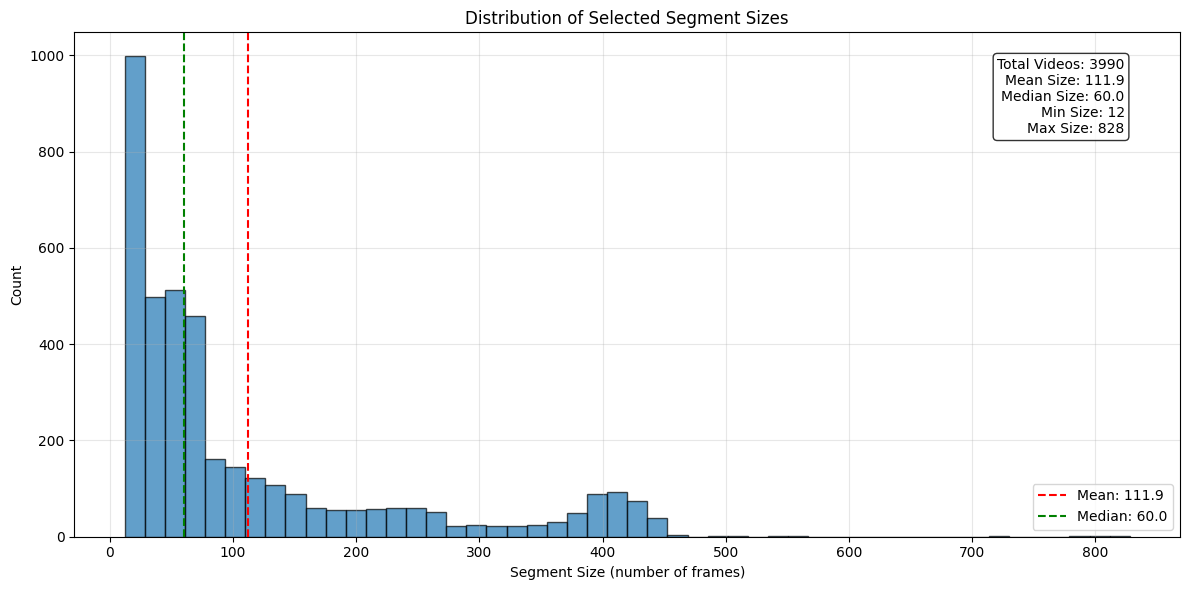


Segment size statistics:
  Mean: 111.91 frames
  Median: 60.00 frames
  Standard deviation: 122.19 frames
  Min: 12 frames
  Max: 828 frames
  25th percentile: 28.2 frames
  75th percentile: 141.0 frames

Step 6: Saving final dataset...
Final dataset saved to: filtered_data_class.json
Total videos in final dataset: 3990
\n============================================================
PIPELINE COMPLETED SUCCESSFULLY


In [14]:
def main_pipeline(json_path: str, pickle_path: str, labels_csv_path: str,
                 output_path: str) -> Dict:
    """
    Execute the complete first segment selection pipeline.

    Args:
        json_path: Path to fish detection results JSON
        pickle_path: Path to multi-fish predictions pickle
        labels_csv_path: Path to species labels CSV
        output_path: Path to save final filtered dataset

    Returns:
        Final dataset with selected segments and species labels
    """
    print("=" * 60)
    print("FISH VIDEO SEGMENT SELECTION PIPELINE")
    print("=" * 60)

    # Step 1: Load and prepare data
    print(f"\nStep 1: Loading detection results...")
    frame_mapping = load_detection_results(json_path, pickle_path)

    # Step 2: Filter multiple fish videos
    print(f"\nStep 2: Filtering multiple fish videos...")
    filter_results = filter_multi_fish_videos(frame_mapping, threshold=0.962, consecutive_frames=2)
    single_fish_data = remove_multi_fish_videos(frame_mapping, filter_results)

    # Step 3: Select first valid segments
    print(f"\nStep 3: Selecting first valid segments...")
    segment_data = select_first_segments(single_fish_data, min_skip=3, min_segment_length=12)

    # Step 4: Add species labels
    print(f"\nStep 4: Adding species labels...")
    labels_df = pd.read_csv(labels_csv_path)
    final_data = add_species_labels(segment_data, labels_df)

    # Step 5: Analyze results
    print(f"\nStep 5: Analyzing segment characteristics...")
    analyze_segment_sizes(final_data)

    # Step 6: Save results
    print(f"\nStep 6: Saving final dataset...")
    with open(output_path, 'w') as f:
        json.dump(final_data, f, indent=4)

    print(f"Final dataset saved to: {output_path}")
    print(f"Total videos in final dataset: {len(final_data)}")

    return final_data

# ============================================================================
# EXAMPLE USAGE
# ============================================================================

if __name__ == "__main__":
    # Define file paths (update these paths according to your data location)
    JSON_PATH = "/content/fish_detection_results.json"
    PICKLE_PATH = "/content/Scores-ViT-SO400M-14-SigLIP-MultipleFish.pkl"
    LABELS_CSV_PATH = "/content/video_df_complete.csv"
    OUTPUT_PATH = "filtered_data_class.json"

    # Execute pipeline
    final_dataset = main_pipeline(
        json_path=JSON_PATH,
        pickle_path=PICKLE_PATH,
        labels_csv_path=LABELS_CSV_PATH,
        output_path=OUTPUT_PATH
    )

    print("\\n" + "=" * 60)
    print("PIPELINE COMPLETED SUCCESSFULLY")
    print("=" * 60)